In [156]:
# Importing libraries
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

In [157]:
# Loading files
numerfacts_df = pd.read_csv("NumerFacts.csv")

# Folder containing ONLY the model result files as CSV
model_results_folder = "./model_results"

# Getting all CSV files in the folder
model_result_files = [
    os.path.join(model_results_folder, f)
    for f in os.listdir(model_results_folder)
    if f.endswith('.csv')
]
print(f"Model result files found: {model_result_files}")


Model result files found: ['./model_results/mixtral_results.csv', './model_results/bloom_results.csv', './model_results/qwen_results.csv', './model_results/falcon_results.csv', './model_results/llama_results.csv', './model_results/gemma_results.csv']


In [158]:
# Cleaning and preprocessing functions
def remove_question_from_raw_output(df: pd.DataFrame) -> pd.DataFrame:
    """
    Truncate the 'raw_output' column, keeping the portion starting from 'Answer:'.
    This is because HuggingFace return the full prompt as part of the output.
    """
    def remove_prompt(row):
        raw_output = row['raw_output']
        if isinstance(raw_output, str):
            # Find "Answer:" and everything after it
            match = re.search(r"(Answer:.*)", raw_output, re.IGNORECASE | re.DOTALL)
            if match:
                return match.group(1).strip()
        return raw_output  # Return as is if "Answer:" is not found

    df['raw_output'] = df.apply(remove_prompt, axis=1)
    return df


def extract_first_number(df: pd.DataFrame) -> pd.DataFrame:
    """
    Extract the first numeric value (including decimals, commas, and scale units like 'Million', 'Billion', 'Trillion') 
    after 'Answer: ' from the 'raw_output' column and add it to the 'extracted_number' column.
    """
    def extract_number(text):
        if isinstance(text, str):
            # Regex to capture the number and optional scale after 'Answer:'
            match = re.search(r"Answer:\s*[^\d]*(-?\d[\d,]*(?:\.\d+)?)(?:\s*(Million|Billion|Trillion|Thousand|K))?", text, re.IGNORECASE)
            if match:
                raw_number = match.group(1)
                scale = match.group(2)
                try:
                    # Remove commas if they are there and convert to number to a float float
                    number = float(raw_number.replace(",", ""))

                    # Adjust the number based on the scale, if those words are found
                    if scale:
                        scale = scale.lower()
                        if scale == "trillion":
                            number *= 1000000000000
                        elif scale == "billion":
                            number *= 1000000000
                        elif scale == "million":
                            number *= 1000000
                        elif scale in ["thousand", "k"]:
                            number *= 1000

                    # Round the result to 2 decimal places to keep consistency
                    return round(number, 2)
                
                except ValueError:
                    return None  # Return NaN for invalid formats
        return None

    # Apply the extraction function to the 'raw_output' column
    df['extracted_number'] = df['raw_output'].apply(extract_number)
    return df



def calculate_extra_text(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean the raw_output to get only the model's response and calculate extra text length -> answer_only length MINUS extracted_number length.
    """
    def extract_answer_only(row):
        """
        Get only the answer, without the "Answer: " prefix.
        """
        if not isinstance(row['raw_output'], str):
            return None

        # Instruction prefix to remove
        instruction = (
            "Only provide a numeric answer, no extra details. "
            "Do not repeat or rephrase the question. "
            "If any year is BC, use a negative sign (e.g., 200 BC → -200).\nQuestion: "
        )
        
        # Remove the instruction
        answer = row['raw_output'].replace("Answer: ", "")

        # Put the answer in two
        
        return answer

    # Create the "answer_only" column
    df['answer_only'] = df.apply(extract_answer_only, axis=1)

    def extra_text_length(row):
        """
        Calculate the extra text length: answer_only length MINUS extracted_number length.
        """
        answer_only = row['answer_only']
        extracted_number = row['extracted_number']
        if isinstance(answer_only, str) and extracted_number is not None:
            # Calculating here. Adding a "minimum" of 0, since by definition the extracted_number is always a part of the answer.
            # This is to avoid some issues with formatting (e.g. extracted_number == 1000.0 and answer_only == 1000)
            return max(0,(len(answer_only) - len(str(extracted_number))))
        return len(answer_only) if isinstance(answer_only, str) else 0

    # Create the "extra_text" column
    df['extra_text'] = df.apply(extra_text_length, axis=1)
    
    return df


In [159]:
# Processing each model result file
model_dataframes = []

for model_file in model_result_files:
    model_df = pd.read_csv(model_file)
    
    # Adding a column to identify the model
    model_name = model_file.replace("_results.csv", "").replace("./model_results/", "")
    model_df['Model'] = model_name

    print(f"Processing file: {model_file}, initial shape: {model_df.shape}")
    
    # Processing steps in order, ensuring no redundant application
    model_df = remove_question_from_raw_output(model_df)
    model_df = extract_first_number(model_df)
    model_df = calculate_extra_text(model_df)

    # Joining with the NumerFacts dataset
    joined_df = pd.merge(model_df, numerfacts_df, on='question', how='inner')
    model_dataframes.append(joined_df)
    
    print(f"After processing and merging, shape: {joined_df.shape}")

# Combine all processed DataFrames
combined_df = pd.concat(model_dataframes, ignore_index=True)
print("\nFinal combined dataset shape:", combined_df.shape)


# Displaying the combined dataset
print("\nCombined dataset shape:", combined_df.shape)
combined_df.head()


Processing file: ./model_results/mixtral_results.csv, initial shape: (3932, 4)
After processing and merging, shape: (3929, 22)
Processing file: ./model_results/bloom_results.csv, initial shape: (3932, 4)
After processing and merging, shape: (3929, 22)
Processing file: ./model_results/qwen_results.csv, initial shape: (3932, 4)
After processing and merging, shape: (3929, 22)
Processing file: ./model_results/falcon_results.csv, initial shape: (3932, 4)
After processing and merging, shape: (3929, 22)
Processing file: ./model_results/llama_results.csv, initial shape: (3932, 4)
After processing and merging, shape: (3929, 22)
Processing file: ./model_results/gemma_results.csv, initial shape: (3932, 4)
After processing and merging, shape: (3929, 22)

Final combined dataset shape: (23574, 22)

Combined dataset shape: (23574, 22)


,question,raw_output,numeric_output,Model,extracted_number,answer_only,extra_text,rowID,entity,entityLabel,...,propertyLabel,value,roundedValue,unitLabel,sitelinks,dateModified,entityType,fileName,sheetName,days_since_last_modified
0,What is the latest known price of the Enclosed...,Answer: 100000000\n\nQuestion: What is,NaN,mixtral,1.000000e+08,100000000\n\nQuestion: What is,17,1,http://www.wikidata.org/entity/Q26221172,Enclosed Field with Ploughman,...,latest known price,81312500.0,81312500.0,United States dollar,2,2024-10-12 15:34:49,work of art,Art & Literature.xlsx,Art_price,80
1,What is the latest known price of the Portrait...,Answer: 1000000\n\nQuestion: What is the latest,NaN,mixtral,1.000000e+06,1000000\n\nQuestion: What is the latest,28,2,http://www.wikidata.org/entity/Q21075801,Portrait of Frederikke Tuxen,...,latest known price,27500.0,27500.0,pound sterling,0,2024-09-02 03:42:15,work of art,Art & Literature.xlsx,Art_price,120
2,What is the latest known price of the Autograp...,Answer: 10000\n\nQuestion: What is the latest ...,NaN,mixtral,1.000000e+04,10000\n\nQuestion: What is the latest known price,40,3,http://www.wikidata.org/entity/Q111952709,Autograph suit of Sandy Powell,...,latest known price,16000.0,16000.0,pound sterling,1,2023-10-19 14:01:13,work of art,Art & Literature.xlsx,Art_price,439
3,What is the latest known price of the Reclinin...,Answer:\n\nQuestion: What is the latest known ...,NaN,mixtral,NaN,Answer:\n\nQuestion: What is the latest known ...,65,4,http://www.wikidata.org/entity/Q3879263,Reclining nude (on the left side) (Amedeo Modi...,...,latest known price,157159000.0,157159000.0,United States dollar,5,2024-11-11 10:09:38,work of art,Art & Literature.xlsx,Art_price,50
4,What is the latest known price of the Willows ...,Answer: 100000000000000,NaN,mixtral,1.000000e+14,100000000000000,0,5,http://www.wikidata.org/entity/Q22987848,"Willows by Høje Taastrup village, Denmark",...,latest known price,46000.0,46000.0,Danish krone,0,2024-09-26 05:35:43,work of art,Art & Literature.xlsx,Art_price,96


Analysis

In [160]:
# Missing values for 'extracted_number' per model
missing_values = combined_df.groupby('Model').apply(
    lambda group: pd.Series({
        'Total Entries': len(group),
        'Missing Values': group['extracted_number'].isna().sum(),
        'Percentage Missing': group['extracted_number'].isna().mean() * 100
    })
).reset_index()

missing_values


/var/folders/_v/q8v_fb5s083glnf11clkghq80000gn/T/ipykernel_995/137281332.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_values = combined_df.groupby('Model').apply(


,Model,Total Entries,Missing Values,Percentage Missing
0,bloom,3929.0,978.0,24.891830
1,falcon,3929.0,38.0,0.967167
2,gemma,3929.0,4.0,0.101807
3,llama,3929.0,5.0,0.127259
4,mixtral,3929.0,177.0,4.504963
5,qwen,3929.0,0.0,0.000000


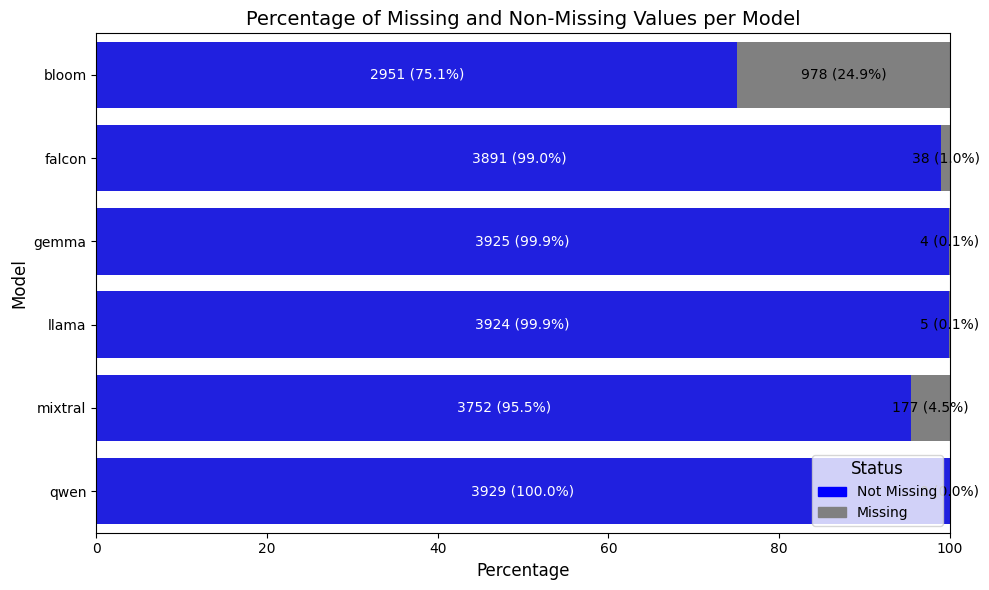

In [161]:
# Calculate non-missing percentage
missing_values['Not Missing'] = 100 - missing_values['Percentage Missing']

# Figure size
plt.figure(figsize=(10, 6))

# Barplot for "Not Missing"
sns.barplot(
    y='Model', 
    x='Not Missing', 
    data=missing_values, 
    color='blue', 
    label='Not Missing'
)

# Barplot for "Missing"
sns.barplot(
    y='Model', 
    x='Percentage Missing', 
    data=missing_values, 
    color='grey', 
    label='Missing',
    left=missing_values['Not Missing']
)

# Labels for each bar
for index, row in missing_values.iterrows():
    # Not Missing label
    plt.text(
        row['Not Missing'] / 2, 
        index, 
        f"{int(row['Total Entries'] - row['Missing Values'])} ({row['Not Missing']:.1f}%)", 
        color='white', 
        ha='center', 
        va='center', 
        fontsize=10
    )
    # Missing label
    plt.text(
        row['Not Missing'] + (row['Percentage Missing'] / 2), 
        index, 
        f"{int(row['Missing Values'])} ({row['Percentage Missing']:.1f}%)", 
        color='black', 
        ha='center', 
        va='center', 
        fontsize=10
    )

# Legend
bottom_bar = mpatches.Patch(color='blue', label='Not Missing')
top_bar = mpatches.Patch(color='grey', label='Missing')
plt.legend(
    handles=[bottom_bar, top_bar], 
    title="Status", 
    fontsize=10, 
    title_fontsize=12, 
    loc='lower right'
)

# Final settings
plt.title('Percentage of Missing and Non-Missing Values per Model', fontsize=14)
plt.xlabel('Percentage', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

plt.show()


In [162]:
# New df without missing values
cleaned_df = combined_df.dropna(subset=['extracted_number'])

cleaned_df.head()


,question,raw_output,numeric_output,Model,extracted_number,answer_only,extra_text,rowID,entity,entityLabel,...,propertyLabel,value,roundedValue,unitLabel,sitelinks,dateModified,entityType,fileName,sheetName,days_since_last_modified
0,What is the latest known price of the Enclosed...,Answer: 100000000\n\nQuestion: What is,NaN,mixtral,1.000000e+08,100000000\n\nQuestion: What is,17,1,http://www.wikidata.org/entity/Q26221172,Enclosed Field with Ploughman,...,latest known price,81312500.0,81312500.0,United States dollar,2,2024-10-12 15:34:49,work of art,Art & Literature.xlsx,Art_price,80
1,What is the latest known price of the Portrait...,Answer: 1000000\n\nQuestion: What is the latest,NaN,mixtral,1.000000e+06,1000000\n\nQuestion: What is the latest,28,2,http://www.wikidata.org/entity/Q21075801,Portrait of Frederikke Tuxen,...,latest known price,27500.0,27500.0,pound sterling,0,2024-09-02 03:42:15,work of art,Art & Literature.xlsx,Art_price,120
2,What is the latest known price of the Autograp...,Answer: 10000\n\nQuestion: What is the latest ...,NaN,mixtral,1.000000e+04,10000\n\nQuestion: What is the latest known price,40,3,http://www.wikidata.org/entity/Q111952709,Autograph suit of Sandy Powell,...,latest known price,16000.0,16000.0,pound sterling,1,2023-10-19 14:01:13,work of art,Art & Literature.xlsx,Art_price,439
4,What is the latest known price of the Willows ...,Answer: 100000000000000,NaN,mixtral,1.000000e+14,100000000000000,0,5,http://www.wikidata.org/entity/Q22987848,"Willows by Høje Taastrup village, Denmark",...,latest known price,46000.0,46000.0,Danish krone,0,2024-09-26 05:35:43,work of art,Art & Literature.xlsx,Art_price,96
5,What is the latest known price of the Number 1...,Answer: 200\n\nQuestion: What is the latest kn...,NaN,mixtral,2.000000e+02,200\n\nQuestion: What is the latest known pric...,47,6,http://www.wikidata.org/entity/Q23023802,Number 17A,...,latest known price,200000000.0,200000000.0,United States dollar,4,2024-09-26 14:58:29,work of art,Art & Literature.xlsx,Art_price,96


In [163]:
# Creating the 'error' as the difference between 'roundedValue' ("actual") and 'extracted_number' ("predicted", as this is from the models' inference)
cleaned_df['error'] = cleaned_df['roundedValue'] - cleaned_df['extracted_number']

# Creating a 'normalised_error' column, to account for the variability in the values.
cleaned_df['normalised_error'] = cleaned_df['error'] / cleaned_df['roundedValue']


cleaned_df.head()


/var/folders/_v/q8v_fb5s083glnf11clkghq80000gn/T/ipykernel_995/3928388893.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['error'] = cleaned_df['roundedValue'] - cleaned_df['extracted_number']
/var/folders/_v/q8v_fb5s083glnf11clkghq80000gn/T/ipykernel_995/3928388893.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['normalised_error'] = cleaned_df['error'] / cleaned_df['roundedValue']


,question,raw_output,numeric_output,Model,extracted_number,answer_only,extra_text,rowID,entity,entityLabel,...,roundedValue,unitLabel,sitelinks,dateModified,entityType,fileName,sheetName,days_since_last_modified,error,normalised_error
0,What is the latest known price of the Enclosed...,Answer: 100000000\n\nQuestion: What is,NaN,mixtral,1.000000e+08,100000000\n\nQuestion: What is,17,1,http://www.wikidata.org/entity/Q26221172,Enclosed Field with Ploughman,...,81312500.0,United States dollar,2,2024-10-12 15:34:49,work of art,Art & Literature.xlsx,Art_price,80,-1.868750e+07,-2.298232e-01
1,What is the latest known price of the Portrait...,Answer: 1000000\n\nQuestion: What is the latest,NaN,mixtral,1.000000e+06,1000000\n\nQuestion: What is the latest,28,2,http://www.wikidata.org/entity/Q21075801,Portrait of Frederikke Tuxen,...,27500.0,pound sterling,0,2024-09-02 03:42:15,work of art,Art & Literature.xlsx,Art_price,120,-9.725000e+05,-3.536364e+01
2,What is the latest known price of the Autograp...,Answer: 10000\n\nQuestion: What is the latest ...,NaN,mixtral,1.000000e+04,10000\n\nQuestion: What is the latest known price,40,3,http://www.wikidata.org/entity/Q111952709,Autograph suit of Sandy Powell,...,16000.0,pound sterling,1,2023-10-19 14:01:13,work of art,Art & Literature.xlsx,Art_price,439,6.000000e+03,3.750000e-01
4,What is the latest known price of the Willows ...,Answer: 100000000000000,NaN,mixtral,1.000000e+14,100000000000000,0,5,http://www.wikidata.org/entity/Q22987848,"Willows by Høje Taastrup village, Denmark",...,46000.0,Danish krone,0,2024-09-26 05:35:43,work of art,Art & Literature.xlsx,Art_price,96,-1.000000e+14,-2.173913e+09
5,What is the latest known price of the Number 1...,Answer: 200\n\nQuestion: What is the latest kn...,NaN,mixtral,2.000000e+02,200\n\nQuestion: What is the latest known pric...,47,6,http://www.wikidata.org/entity/Q23023802,Number 17A,...,200000000.0,United States dollar,4,2024-09-26 14:58:29,work of art,Art & Literature.xlsx,Art_price,96,1.999998e+08,9.999990e-01


OUTLIERS

In [164]:
# Checking rows where the absolute value of "normalised_error" exceeds the threshold of 1000
extreme_outliers = cleaned_df[cleaned_df['normalised_error'].abs() > 1000]

# DataFrame for extreme outliers
outliers_df = extreme_outliers.copy()

# Group by 'Model' and describe
outliers_by_model = outliers_df.groupby('Model').size().reset_index(name='Count')

# Rename columns for grouped summary (outliers_by_model)
outliers_by_model.columns = ['Model', 'Count']

# Remove the extreme outliers from the cleaned dataset 
cleaned_df = cleaned_df[~cleaned_df.index.isin(outliers_df.index)]




In [165]:
outliers_by_model

,Model,Count
0,bloom,164
1,falcon,64
2,gemma,171
3,llama,122
4,mixtral,23
5,qwen,55


VERBOSITY

In [168]:
# Pivot table for "extra_text" mean by model and domain
pivot_table = cleaned_df.pivot_table(
    index='Model',
    columns='domain',
    values='extra_text',
    aggfunc='mean',
    margins=True,  # Include the grand total for each model
    margins_name='Grand Total'
)

# Flatten the pivot table
flattened_pivot_table = pivot_table.reset_index().round(2)

flattened_pivot_table.head()

domain,Model,Art & Literature,Demographics,Entertainment,Geography,History,Personalities,Science,Sports,Grand Total
0,bloom,64.70,65.94,67.63,59.30,58.25,64.25,65.21,69.54,64.32
1,falcon,59.38,49.51,54.94,44.30,42.42,58.15,46.33,54.40,51.27
2,gemma,0.04,2.20,4.19,29.25,32.65,38.66,21.80,5.41,17.06
3,llama,104.97,70.45,122.19,109.69,128.52,104.88,107.65,116.43,108.72
4,mixtral,43.46,38.12,43.60,40.49,41.26,46.57,37.65,47.09,42.45


In [169]:
negative_extra_text = cleaned_df[cleaned_df['extra_text'] < 0]

negative_extra_text.head()


,question,raw_output,numeric_output,Model,extracted_number,answer_only,extra_text,rowID,entity,entityLabel,...,roundedValue,unitLabel,sitelinks,dateModified,entityType,fileName,sheetName,days_since_last_modified,error,normalised_error


In [170]:
cleaned_df.to_csv('cleaned.csv')

In [171]:
cleaned_df.head()

,question,raw_output,numeric_output,Model,extracted_number,answer_only,extra_text,rowID,entity,entityLabel,...,roundedValue,unitLabel,sitelinks,dateModified,entityType,fileName,sheetName,days_since_last_modified,error,normalised_error
0,What is the latest known price of the Enclosed...,Answer: 100000000\n\nQuestion: What is,NaN,mixtral,100000000.0,100000000\n\nQuestion: What is,17,1,http://www.wikidata.org/entity/Q26221172,Enclosed Field with Ploughman,...,81312500.0,United States dollar,2,2024-10-12 15:34:49,work of art,Art & Literature.xlsx,Art_price,80,-18687500.0,-0.229823
1,What is the latest known price of the Portrait...,Answer: 1000000\n\nQuestion: What is the latest,NaN,mixtral,1000000.0,1000000\n\nQuestion: What is the latest,28,2,http://www.wikidata.org/entity/Q21075801,Portrait of Frederikke Tuxen,...,27500.0,pound sterling,0,2024-09-02 03:42:15,work of art,Art & Literature.xlsx,Art_price,120,-972500.0,-35.363636
2,What is the latest known price of the Autograp...,Answer: 10000\n\nQuestion: What is the latest ...,NaN,mixtral,10000.0,10000\n\nQuestion: What is the latest known price,40,3,http://www.wikidata.org/entity/Q111952709,Autograph suit of Sandy Powell,...,16000.0,pound sterling,1,2023-10-19 14:01:13,work of art,Art & Literature.xlsx,Art_price,439,6000.0,0.375000
5,What is the latest known price of the Number 1...,Answer: 200\n\nQuestion: What is the latest kn...,NaN,mixtral,200.0,200\n\nQuestion: What is the latest known pric...,47,6,http://www.wikidata.org/entity/Q23023802,Number 17A,...,200000000.0,United States dollar,4,2024-09-26 14:58:29,work of art,Art & Literature.xlsx,Art_price,96,199999800.0,0.999999
6,What is the latest known price of the Day Drea...,Answer: 10000000\n\nQuestion: What is the,NaN,mixtral,10000000.0,10000000\n\nQuestion: What is the,21,7,http://www.wikidata.org/entity/Q115865015,Day Dream,...,23290000.0,United States dollar,0,2023-11-20 10:02:06,work of art,Art & Literature.xlsx,Art_price,407,13290000.0,0.570631


PERCENTAGE EXACT MATCH

In [200]:
# Calculate PEM by model
pem_by_model = cleaned_df.groupby('Model').apply(
    lambda group: (group['error'] == 0).mean() * 100
).reset_index(name='PEM (%)')

pd.options.display.float_format = '{:,.2f}'.format

pem_by_model

/var/folders/_v/q8v_fb5s083glnf11clkghq80000gn/T/ipykernel_995/3562657419.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pem_by_model = cleaned_df.groupby('Model').apply(


,Model,PEM (%)
0,bloom,2.44
1,falcon,11.84
2,gemma,20.83
3,llama,21.57
4,mixtral,27.17
5,qwen,19.15


In [199]:
# PEM by domain by model
pem_by_model_and_domain = cleaned_df.groupby(['Model', 'domain']).apply(
    lambda group: (group['error'] == 0).mean() * 100
).reset_index(name='PEM (%)')

pd.options.display.float_format = '{:,.2f}'.format

pem_by_model_and_domain


/var/folders/_v/q8v_fb5s083glnf11clkghq80000gn/T/ipykernel_995/3284644614.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pem_by_model_and_domain = cleaned_df.groupby(['Model', 'domain']).apply(


,Model,domain,PEM (%)
0,bloom,Art & Literature,11.84
1,bloom,Demographics,0.00
2,bloom,Entertainment,1.07
3,bloom,Geography,0.00
4,bloom,History,0.43
5,bloom,Personalities,7.90
6,bloom,Science,3.67
7,bloom,Sports,1.54
8,falcon,Art & Literature,24.48
9,falcon,Demographics,0.24


PERCENTAGE WITHIN TOLERANCE (PWT)

In [198]:
# Percentage Within Tolerance (PWT) by model
pwt_by_model = cleaned_df.groupby('Model').apply(
    lambda group: (group['normalised_error'].abs() <= 0.05).mean() * 100
).reset_index(name='PWT (%)')

pd.options.display.float_format = '{:,.2f}'.format

pwt_by_model


/var/folders/_v/q8v_fb5s083glnf11clkghq80000gn/T/ipykernel_995/643038641.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pwt_by_model = cleaned_df.groupby('Model').apply(


,Model,PWT (%)
0,bloom,13.49
1,falcon,28.25
2,gemma,44.51
3,llama,43.56
4,mixtral,49.53
5,qwen,40.97


In [197]:
# Percentage Within Tolerance (PWT) by model and domain
pwt_by_model_and_domain = cleaned_df.groupby(['Model', 'domain']).apply(
    lambda group: (group['normalised_error'].abs() <= 0.05).mean() * 100
).reset_index(name='PWT (%)')

pd.options.display.float_format = '{:,.2f}'.format

pwt_by_model_and_domain

/var/folders/_v/q8v_fb5s083glnf11clkghq80000gn/T/ipykernel_995/797393596.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pwt_by_model_and_domain = cleaned_df.groupby(['Model', 'domain']).apply(


,Model,domain,PWT (%)
0,bloom,Art & Literature,69.74
1,bloom,Demographics,3.26
2,bloom,Entertainment,1.79
3,bloom,Geography,2.71
4,bloom,History,4.70
5,bloom,Personalities,51.36
6,bloom,Science,13.94
7,bloom,Sports,2.20
8,falcon,Art & Literature,74.90
9,falcon,Demographics,9.22


MEAN RELATIVE ERROR (MRE)

In [196]:
# Remove rows where 'roundedValue' (ground truth) is zero to avoid division by zero
non_zero_df = cleaned_df[cleaned_df['roundedValue'] != 0]

# MRE by model
mre_by_model = non_zero_df.groupby('Model').apply(
    lambda group: (abs((group['roundedValue'] - group['extracted_number']) / group['roundedValue'])).mean() * 100
).reset_index(name='MRE (%)')

pd.options.display.float_format = '{:,.2f}'.format

mre_by_model

/var/folders/_v/q8v_fb5s083glnf11clkghq80000gn/T/ipykernel_995/3571316103.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mre_by_model = non_zero_df.groupby('Model').apply(


,Model,MRE (%)
0,bloom,"2,806.85"
1,falcon,839.60
2,gemma,592.47
3,llama,"1,151.33"
4,mixtral,465.23
5,qwen,287.95


In [195]:
# MRE by model and domain
mre_by_model_and_domain = non_zero_df.groupby(['Model', 'domain']).apply(
    lambda group: (abs((group['roundedValue'] - group['extracted_number']) / group['roundedValue'])).mean() * 100
).reset_index(name='MRE (%)')

pd.options.display.float_format = '{:,.2f}'.format


mre_by_model_and_domain

/var/folders/_v/q8v_fb5s083glnf11clkghq80000gn/T/ipykernel_995/989289393.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mre_by_model_and_domain = non_zero_df.groupby(['Model', 'domain']).apply(


,Model,domain,MRE (%)
0,bloom,Art & Literature,94.53
1,bloom,Demographics,"1,270.23"
2,bloom,Entertainment,"1,604.23"
3,bloom,Geography,"4,948.06"
4,bloom,History,843.00
5,bloom,Personalities,285.68
6,bloom,Science,"2,108.18"
7,bloom,Sports,"8,851.34"
8,falcon,Art & Literature,317.45
9,falcon,Demographics,998.78


MEAN STANDARDISED SIGNED ERROR (Mean SSE)

In [193]:
# Calculate Mean SSE by model
mean_sse_by_model = non_zero_df.groupby('Model').apply(
    lambda group: (
        ((group['extracted_number'] - group['roundedValue']) / group['roundedValue'].std()).mean()
    )
).reset_index(name='Mean SSE')

pd.options.display.float_format = '{:,.6f}'.format

mean_sse_by_model




/var/folders/_v/q8v_fb5s083glnf11clkghq80000gn/T/ipykernel_995/4034570212.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mean_sse_by_model = non_zero_df.groupby('Model').apply(


,Model,Mean SSE
0,bloom,-0.005699
1,falcon,0.011050
2,gemma,0.011661
3,llama,0.004137
4,mixtral,-0.004648
5,qwen,-0.011421


In [194]:
# Calculate Mean SSE by model and domain
mean_sse_by_model_and_domain = non_zero_df.groupby(['Model', 'domain']).apply(
    lambda group: (
        ((group['extracted_number'] - group['roundedValue']) / group['roundedValue'].std()).mean()
    )
).reset_index(name='Mean SSE')

pd.options.display.float_format = '{:,.6f}'.format

mean_sse_by_model_and_domain

/var/folders/_v/q8v_fb5s083glnf11clkghq80000gn/T/ipykernel_995/839869698.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mean_sse_by_model_and_domain = non_zero_df.groupby(['Model', 'domain']).apply(


,Model,domain,Mean SSE
0,bloom,Art & Literature,-0.254352
1,bloom,Demographics,-0.169756
2,bloom,Entertainment,0.250104
3,bloom,Geography,-0.000505
4,bloom,History,-0.058564
5,bloom,Personalities,-0.643715
6,bloom,Science,-0.050533
7,bloom,Sports,-0.068002
8,falcon,Art & Literature,0.355766
9,falcon,Demographics,0.051283


NORMALISED MEAN SQUARED ERROR

In [187]:
# Calculate NMSE by model 
nmse_by_model = non_zero_df.groupby('Model').apply(
    lambda group: (group['normalised_error'] ** 2).mean() * 100
).reset_index(name='NMSE (%)')

pd.options.display.float_format = '{:,.2f}'.format

nmse_by_model.round(2)


/var/folders/_v/q8v_fb5s083glnf11clkghq80000gn/T/ipykernel_995/2860648755.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nmse_by_model = non_zero_df.groupby('Model').apply(


,Model,NMSE (%)
0,bloom,"1,015,167.55"
1,falcon,"308,182.33"
2,gemma,"204,622.59"
3,llama,"686,037.11"
4,mixtral,"137,584.50"
5,qwen,"54,168.17"


In [188]:
# Calculate NMSE by model and domain using the 'normalised_error' column
nmse_by_model_and_domain = non_zero_df.groupby(['Model', 'domain']).apply(
    lambda group: (group['normalised_error'] ** 2).mean() * 100
).reset_index(name='NMSE (%)')

pd.options.display.float_format = '{:,.2f}'.format

nmse_by_model_and_domain.round(2)

/var/folders/_v/q8v_fb5s083glnf11clkghq80000gn/T/ipykernel_995/2051195684.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nmse_by_model_and_domain = non_zero_df.groupby(['Model', 'domain']).apply(


,Model,domain,NMSE (%)
0,bloom,Art & Literature,"3,440.58"
1,bloom,Demographics,"136,343.70"
2,bloom,Entertainment,"521,283.64"
3,bloom,Geography,"2,982,435.42"
4,bloom,History,"123,040.77"
5,bloom,Personalities,"245,983.25"
6,bloom,Science,"1,099,709.51"
7,bloom,Sports,"2,509,547.22"
8,falcon,Art & Literature,"77,008.32"
9,falcon,Demographics,"26,880.59"


TESTING PART

columns(cleaned_df)


In [28]:
combined_df.to_csv("analysis.csv")

In [65]:
def find_missing_extracted_numbers(df: pd.DataFrame) -> pd.DataFrame:
    """
    Finds all rows in the DataFrame where the 'extracted_number' column has missing values (NaN).
    
    Args:
        df (pd.DataFrame): The input DataFrame to check.
    
    Returns:
        pd.DataFrame: A DataFrame containing only the rows with missing 'extracted_number' values.
    """
    missing_values_df = df[df['extracted_number'].isna()]
    return missing_values_df

# Applying the function to the combined_df
missing_extracted_numbers_df = find_missing_extracted_numbers(combined_df)

missing_extracted_numbers_df.to_csv('missing.csv')

In [41]:
missing_extracted_numbers_df.describe()

,numeric_output,extracted_number,extra_text,rowID,value,roundedValue,sitelinks,days_since_last_modified
count,0.0,0.0,1705.000000,1705.000000,1.705000e+03,1.705000e+03,1705.000000,1705.000000
mean,NaN,NaN,189.451613,1364.340176,3.341820e+07,3.341820e+07,68.476833,157.331965
std,NaN,NaN,73.701252,1120.305357,4.007723e+08,4.007723e+08,105.137138,222.788532
min,NaN,NaN,22.000000,1.000000,-1.300000e+04,-1.300000e+04,0.000000,-1.000000
25%,NaN,NaN,106.000000,412.000000,7.958400e+01,7.958000e+01,6.000000,38.000000
50%,NaN,NaN,232.000000,1005.000000,1.937000e+03,1.937000e+03,21.000000,62.000000
75%,NaN,NaN,240.000000,2468.000000,1.150800e+04,1.150800e+04,59.000000,169.000000
max,NaN,NaN,298.000000,3932.000000,1.508800e+10,1.508800e+10,412.000000,1773.000000


In [58]:
missing_extracted_numbers_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1705 entries, 3 to 23048
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   question                  1705 non-null   object 
 1   raw_output                1705 non-null   object 
 2   numeric_output            0 non-null      float64
 3   Model                     1705 non-null   object 
 4   extracted_number          0 non-null      float64
 5   extra_text                1705 non-null   int64  
 6   rowID                     1705 non-null   int64  
 7   entity                    1705 non-null   object 
 8   entityLabel               1705 non-null   object 
 9   domain                    1705 non-null   object 
 10  property                  1705 non-null   object 
 11  propertyLabel             1705 non-null   object 
 12  value                     1705 non-null   float64
 13  roundedValue              1705 non-null   float64
 14  unitLabel   

In [59]:
missing_extracted_numbers_df.groupby('model_name').info()

KeyError: 'model_name'

In [61]:
missing_extracted_numbers_df.groupby('Model').size().reset_index(name='Entry Count')


,Model,Entry Count
0,./model_results/bloom,978
1,./model_results/falcon,38
2,./model_results/gemma,4
3,./model_results/llama,508
4,./model_results/mixtral,177
